## Perceptual decision making

### 1. Data generation
$u(t)= \bigg\{ \begin{array}{ll} \bar{u} + \xi (t) & \text{if } 5 \leq t \leq 45 \\  \xi (t) & otherwise \end{array}$

$\bar{u}$ stimulus strength, drawn from a uniformormly from $\pm \frac{3.2}{100} \{1,2,4,8,16\}$ 

$\xi (t)$ is background noise, drawn from a normal distribution with mean 0 and standard deviation 0.03. 

resample for each trial. noise resampled for each time step. 

target $y$ is $sgn(\bar{u})$

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# #%matplotlib inline

In [17]:
def data(n_trials):
    """
    Generate perceptual decision-making data.
    
    Parameters
    ----------
    n_trials : int
        Number of trials.
    n_time_step : 50
        Number of time steps.
    Returns
    -------
    u : array, shape (n_trials,n_time_step)
        input 
    y : array, shape (n_trials,n_time_step)
        output 
    """
    strength_choices = (3.2/ 100)  * np.array([1,2,4,8,16, -1,-2,-4,-8,-16])
    n_time_step = 75
    time_step= 20 #ms

    u = np.zeros([n_trials,n_time_step])
    y = np.zeros([n_trials,n_time_step])
    
    for trial in range(n_trials):
        strength = np.random.choice(strength_choices)

        for t in range(0,n_time_step):
            if t>=5 and t<=45:
                #noise with std 0.03
                u[trial,t] = strength + np.random.normal(0,0.03)
            else:
                u[trial, t] = np.random.normal(0,0.03)
            
            y[trial, t] = np.sign(strength)
    
    return u,y

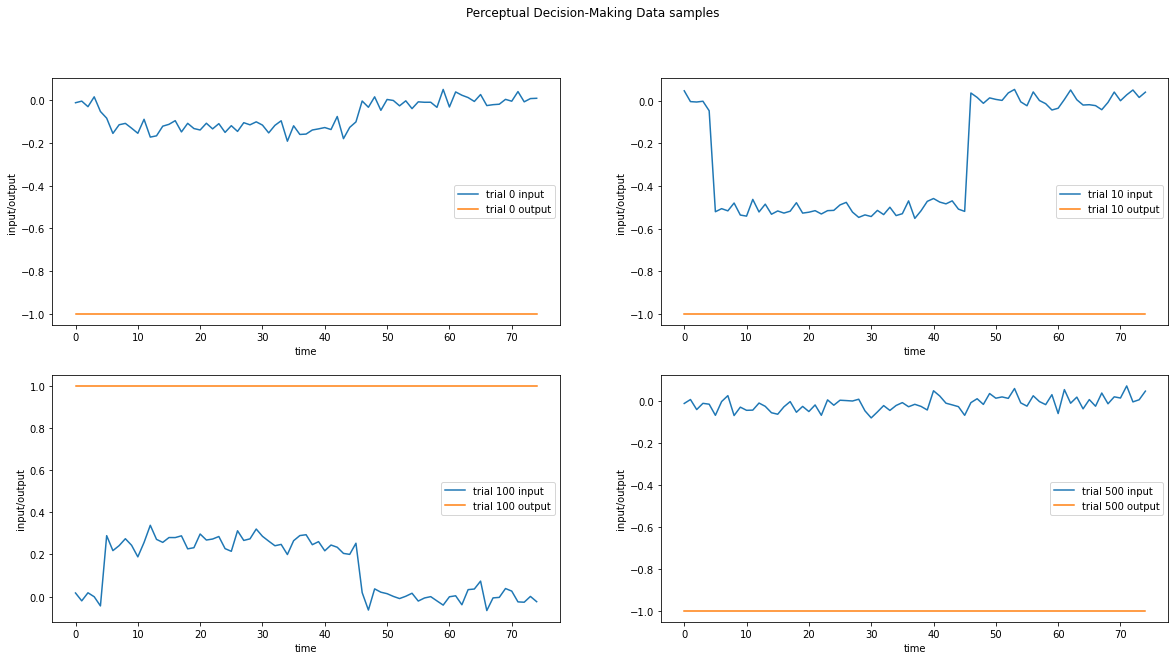

In [18]:
u,y = data(n_trials=1000)
i=0
plt.figure(figsize=(20,10))
plt.suptitle('Perceptual Decision-Making Data samples')
for trail in [0,10, 100, 500]:
    plt.subplot(2,2,i+1)
    plt.plot(u[trail,:], label='trial {} input'.format(trail))
    plt.plot(y[trail,:], label='trial {} output'.format(trail))
    plt.xlabel('time')
    plt.ylabel('input/output')
    plt.legend()
    i+=1

### 2. Recurrent neural network
one dimensional input and output, 

N units in the hidden layer, 

left and right connectivity vector $m, n$ trainable parameters, 

fixed input and output weights $I, W$. 

trainable and fixed weights are drawn from standard normal distribution. 

$\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^N J_{ij} \phi(x_j) + I_i u(t)$ 

$\phi(x) = \tanh$ 

$\tau = 100 ms$ 
 
$\Delta t = 20 ms$ 

$J = \frac{1}{N} mn^T$ 

Using forward Euler method to solve the differential equation. 

$x_i(t+ \Delta t) = x_i(t) + \frac{1}{\tau}  \Delta t  \bigg( -x_i(t) + \sum_{j=1}^N J_{ij} \phi(x_j(t)) + I_i u(t) \bigg)$